In [62]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 10

In [63]:
import csv
import glob
from collections import defaultdict
import pandas as pd
import numpy as np

In [64]:
#From http://rosettacode.org/wiki/Set_consolidation#Python
def consolidate(sets):
    setlist = [set(s) for s in sets if s] # convert to mutable_set
    for i, s1 in enumerate(setlist):
        if s1:
            for s2 in setlist[i+1:]:
                intersection = s1.intersection(s2)
                if intersection:
                    s2.update(s1)
                    s1.clear()
                    s1 = s2
    return [frozenset(s) for s in setlist if s]

In [65]:

def load_paraphrase_groups():
    for filename in glob.glob("opinosis_split/*"):
        table = pd.read_csv(filename, delimiter='\t', header=None,  encoding = "ISO-8859-1")
        
        for col_num in range(1,table.shape[1]): #Skip column zero as that contains unsorted entrys
            pf_group = table.iloc[:,col_num].dropna().tolist()
            if len(pf_group)>0:
                yield pf_group


In [66]:
def postprocess(sentence):
    import re
    def replace_broken_hypen(first_half, second_half, sentence):
        pattern = r"(?<=%s),\s?(?=%s)" % (first_half, second_half)
        return re.sub(pattern, "-",sentence,flags=re.IGNORECASE)
    
    sentence=sentence.strip()
    sentence=re.sub(r"^\d\s(?! hour|out|block)","",sentence,flags=re.IGNORECASE) #remove starting numbers
    sentence=re.sub(r"^([\.\,\-\!\?\;\:\>]\s*)+","",sentence) #remove starting punctuation

    sentence=re.sub(r"(,\s?)+",", ",sentence) #remove repeated commas
    sentence =sentence.replace("&quot", "\"")
    sentence =sentence.replace("&amp", "\"")
   
    sentence =replace_broken_hypen("e", "ink", sentence)
    sentence =replace_broken_hypen("non", "smoking", sentence)
    sentence =replace_broken_hypen("on", "line", sentence)
    return sentence

In [67]:
[frozenset({',  The one thing this hotel has it going for it is the location .',
            'Location is the only thing it has going for it .',
            'Location itself is great, but everything else is terrible .',
            'The single thing to recommend this hotel is the location, which is excellent .'})]

[frozenset({',  The one thing this hotel has it going for it is the location .',
            'Location is the only thing it has going for it .',
            'Location itself is great, but everything else is terrible .',
            'The single thing to recommend this hotel is the location, which is excellent .'})]

In [68]:
pf_groups = list(load_paraphrase_groups())
pf_groups = [frozenset(map(postprocess, group)) for group in pf_groups]
pf_groups = consolidate(pf_groups)

In [69]:
pf_groups = [group for group in pf_groups if len(group)>1]

In [70]:
pf_group_sizes = pd.Series(list(map(len,pf_groups)))
pf_group_sizes.describe()

count    163.000000
mean       4.104294
std        4.572615
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       33.000000
dtype: float64

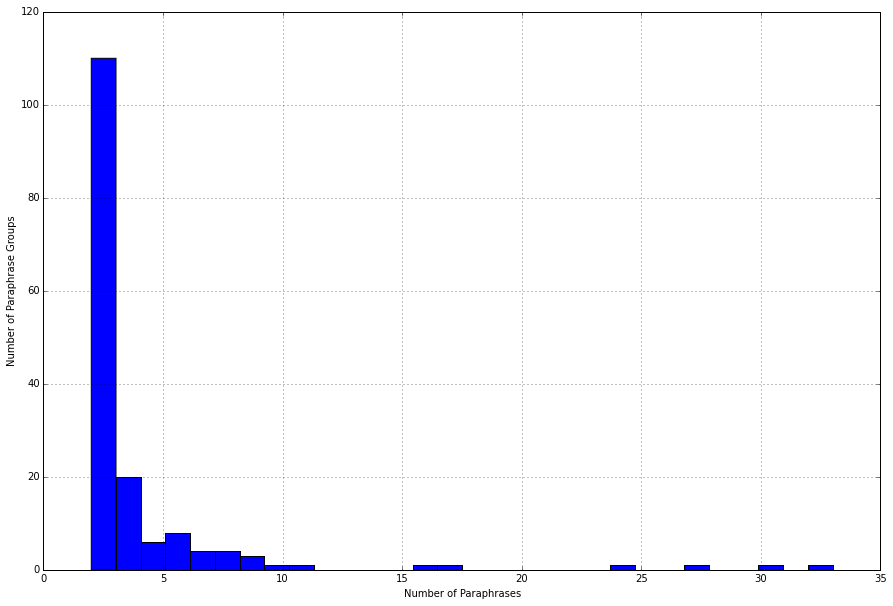

In [71]:
pl.xlabel("Number of Paraphrases")
pl.ylabel("Number of Paraphrase Groups")
plt = pf_group_sizes.hist(bins=30, ax=pl.gca())

In [72]:
pf_groups

[frozenset({'The keyboard, though slightly smaller than standard, is a pleasure to use .',
            'keyboard is actually a pleasure to use inspite of small size'}),
 frozenset({"It's 90% size keyboard doesn't take too long to get used to .",
            'Speaking of typing, the keyboard is great, almost full size .',
            "Speaking of which, the keyboard's relatively large size ,  at 92% of the size of a normal one ,  writing longer texts on it is no problem .",
            'The keyboard is large enough to accommodate touch typing with ease .',
            'The keyboard is nearly full size and very comfortable to type on for hours .',
            "The keyboard is only slightly smaller than a regular one, so it's very comfortable .",
            'The keyboard, more than 90% standard size, is just large enough .'}),
 frozenset({'Keyboard feels funny at first, but you get used to it .',
            'The keyboard is functional, but takes a little bit of getting use to .',
      

In [73]:
def save(pf_groups, save_dir):
    from os.path import join as pathjoin
    import csv
    
    with open(pathjoin(save_dir,"phrases.txt"),"w") as phrases_fh:
        with open(pathjoin(save_dir,"phrase_groups.csv"),"w") as groups_fh:
            group_csv = csv.writer(groups_fh)
            group_csv.writerow(["phrase_index","paraphrase_group_index"])
            phrase_index = 0;
            for group_index, group in enumerate(pf_groups):
                for phrase in group:
                    phrases_fh.write(phrase)
                    phrases_fh.write("\n")
                    
                    group_csv.writerow([phrase_index,group_index])

                    phrase_index+=1
                

In [74]:
save(pf_groups, "prepared_corpora/opinosis/")

In [76]:
!git push

Counting objects: 13, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (13/13), 204.63 KiB | 0 bytes/s, done.
Total 13 (delta 9), reused 0 (delta 0)
To git@github.com:oxinabox/phd.git
   2fd5523..a250868  master -> master
